<a href="https://colab.research.google.com/github/GermanOmar/LAFW/blob/master/LARFW_IJAMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting the Ultimate Tensile Strength of AISI 1045 steel and 2017-T4 aluminum alloy joints in a laser-assisted rotary friction welding process using Machine learning




<a href="https://ibb.co/h2Prbq5"><img src="https://i.ibb.co/2cDRxb2/Imagen1.png" WIDTH="329" HEIGHT="713"  border="0"></a>

 Libraries

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.utils import shuffle

 Upload database:

In [ ]:
!git clone https://github.com/GermanOmar/LAFW

Cloning into 'LAFW'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 31 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), done.


In [ ]:
#Experimental data
data = pd.read_table('data.txt') 
data.describe()


,N,FP,LP,UTS
count,48.000000,48.000000,48.000000,48.000000
mean,1700.000000,17.500000,600.000000,148.130417
std,101.058231,3.537038,378.125275,40.693220
min,1600.000000,14.000000,0.000000,60.300000
25%,1600.000000,14.000000,450.000000,114.300000
50%,1700.000000,17.500000,700.000000,149.750000
75%,1800.000000,21.000000,850.000000,176.825000
max,1800.000000,21.000000,1000.000000,215.400000



Setting inputs - output:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  app.launch_new_instance()


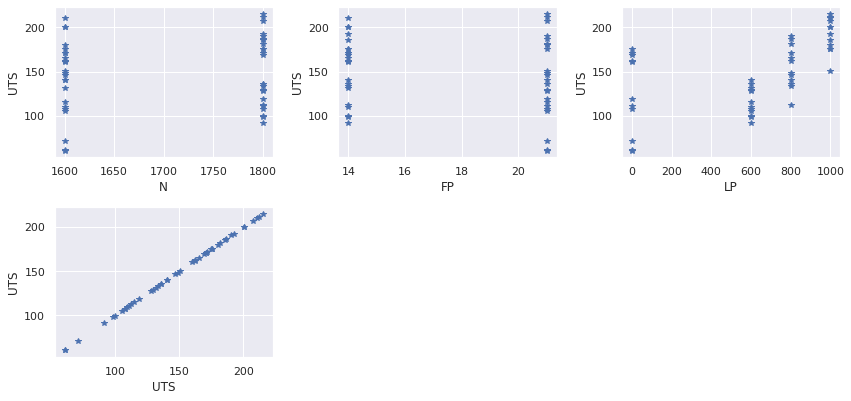

In [ ]:
fields = [ 'N', 'FP','LP', 'UTS']
import seaborn as sns
sns.set()

fig = plt.figure()
fig.set_size_inches((12,8))
for i, field in enumerate(fields):
  plt.subplot(3, 3, i + 1)
  plt.plot(data[field], data['UTS'], 'b*')
  plt.xlabel(field)
  plt.ylabel('UTS')

plt.tight_layout()

X=data[[ 'N', 'FP','LP']]
Y=data['UTS'][:,None]



#fig.tight_layout()

Normalization

In [ ]:
def normalize(X, X_mu, X_std):
  return (X - X_mu)/X_std

def denormalize(Xn, X_mu, X_std):
  return Xn*X_std + X_mu

X_std = X.std(0)
X_mu = X.mean(0)
Xn = normalize(X, X_mu, X_std)

Y_std = Y.std(0)
Y_mu = Y.mean(0)
Yn = normalize(Y, Y_mu, Y_std)

 Split data

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xn, Yn, test_size=0.2, random_state=42)
print('training samples:', X_train.shape[0],  ' test samples:', X_test.shape[0])

training samples: 38  test samples: 10


#Results:

###GBR 

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
#KERNEL
#GBR=GradientBoostingRegressor(n_estimators=100, random_state=0)
GBR=GradientBoostingRegressor(n_estimators=2000, random_state=32, learning_rate=0.1 )

#START TRAINING
GBR.fit(X_train,y_train)
#PREDICTION
y_pred=GBR.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

 
print("-Gradient boosting regressor-")
print("-----------------------------")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()



/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-Gradient boosting regressor-
-----------------------------
MSE test: 0.03886862392437257

R2:  0.975982496414206
RMSE:  0.19715127167830435
MAE:  0.18251922500723944
IM:  0.26973826554663966



### GPs

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
 
GP=GPR(kernel=kernel, n_restarts_optimizer=9, alpha=0.01, normalize_y=True)
 
#Training
GP.fit(X_train,y_train)
 
#Testing
y_star_train = GP.predict(X_train)
y_pred = GP.predict(X_test)
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("Gaussian Process")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_pred)
print('R2_test: ',R2_test)
print()
""" 
RE=100 * abs(y_test - y_pred) / y_test
print('Relative error (%): ',RE)
"""
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 
#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()


Gaussian Process
MSE train: 0.027006448127979116
MSE test: 0.03863634942512476
MSE train < MSE test? True

R2_train:  0.9674943976255849
R2_test:  0.9761260222984623

R2:  0.9761260222984623
RMSE:  0.1965613121270937
MAE:  0.18048521001235018
IM:  0.267920188245717



### RFR

In [ ]:
from sklearn.ensemble import RandomForestRegressor
#KERNEL
RFR=RandomForestRegressor(n_estimators=2000,max_depth=20)

#START TRAINING
RFR.fit(X_train,y_train)
#PREDICTION
y_pred=RFR.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print("-----------------------------")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


-----------------------------
MSE test: 0.13532062112623916

R2:  0.9163833659391948
RMSE:  0.3678595127575732
MAE:  0.2659249837746852
IM:  0.4615500618713688



### XGB

In [ ]:
import pickle
import xgboost as xgb

xgbr = xgb.XGBRegressor(verbosity=0, n_estimators=2000, max_depth=20)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

In [ ]:
print(xgbr)



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=20, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)


In [ ]:
score = xgbr.score(X_test, y_test)  
print("Training score: ", score)

Training score:  0.9758883557162752


In [ ]:
print("-XGBRegressor -")
print("------------------")

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

-XGBRegressor -
------------------
MSE test: 0.039020976119128366

R2:  0.9758883557162752
RMSE:  0.19753727779618804
MAE:  0.1831962935970453
IM:  0.270487022788318



Feature: 0, Score: 0.09419
Feature: 1, Score: 0.28351
Feature: 2, Score: 0.62230


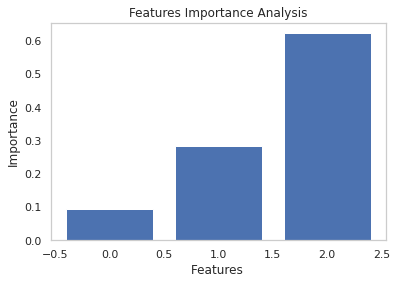

In [ ]:
# get importance
importance = xgbr.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
sns.set_theme(style="whitegrid")
plt.rcParams["axes.grid"] = False

plt.bar([x for x in range(len(importance))], importance)
plt.ylabel('Importance')
plt.xlabel('Features ')
plt.title("Features Importance Analysis")
plt.show()

### MLP

In [ ]:
from sklearn.neural_network import MLPRegressor

MLP = MLPRegressor(hidden_layer_sizes=4,solver='lbfgs',learning_rate='adaptive',activation='relu',random_state=42, max_iter=2000)
#MLP = MLPRegressor(hidden_layer_sizes=(1000,1000,1000), activation='relu', solver='adam', max_iter=800)

#START TRAINING
MLP.fit(X_train,y_train)
#PREDICTION
y_pred=MLP.predict(X_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()



R2:  0.969351627934105
RMSE:  0.19753727779618804
MAE:  0.18070869553550756
IM:  0.26947343370277277



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### DTR

In [ ]:
from sklearn.tree import DecisionTreeRegressor
DT=DecisionTreeRegressor(max_depth=20)

#START TRAINING
DT.fit(X_train,y_train)
#PREDICTION
y_pred=DT.predict(X_test)
print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()



R2:  0.9760461263765746
RMSE:  0.19753727779618804
MAE:  0.18266772943682477
IM:  0.27011527827633225



## SVM

In [ ]:
from sklearn.svm import SVR
SVM=SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.01, coef0=1)

#START TRAINING
SVM.fit(X_train,y_train)
#PREDICTION
y_pred=SVM.predict(X_test)
print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()


R2:  0.9730022681334038
RMSE:  0.19753727779618804
MAE:  0.19725499044404946
IM:  0.2804628048425513



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Comparisson

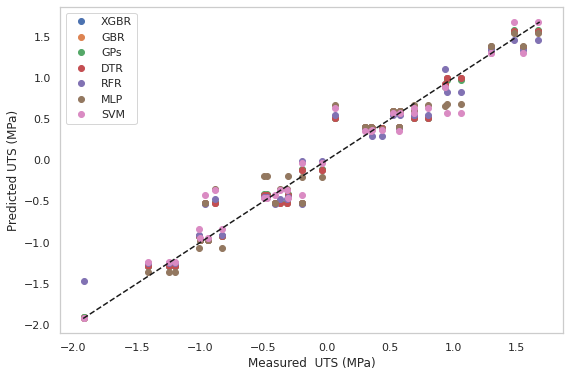

In [ ]:
#TRAIN
models = [xgbr,  GBR,  GP, DT,  RFR , MLP, SVM]
labels = ['XGBR',  'GBR',   'GPs', 'DTR',  'RFR', 'MLP', 'SVM']

sns.set_theme(style="whitegrid")
plt.rcParams["axes.grid"] = False
fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X_train)
  plt.plot(y_train, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('Predicted UTS (MPa)')
plt.xlabel('Measured  UTS (MPa)')
plt.legend()  
  

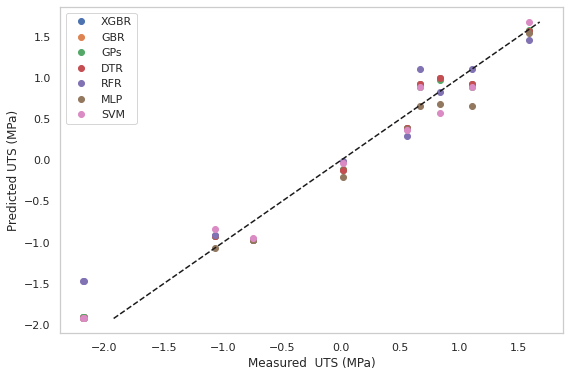

In [ ]:
#TEST
models = [xgbr,  GBR,  GP, DT,  RFR , MLP, SVM]
labels = ['XGBR',  'GBR',   'GPs', 'DTR',  'RFR', 'MLP', 'SVM']

fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X_test)
  plt.plot(y_test, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('Predicted UTS (MPa)')
plt.xlabel('Measured  UTS (MPa)')
plt.legend()  

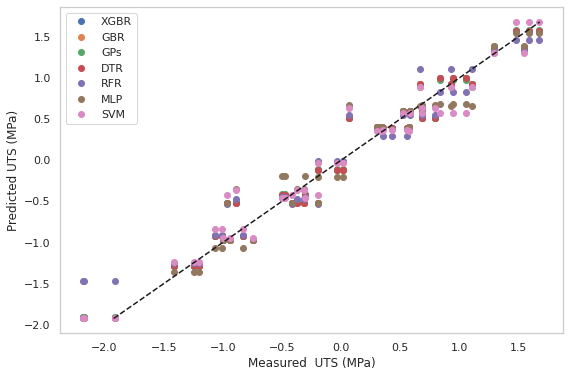

In [ ]:
models = [xgbr,  GBR,  GP, DT,  RFR , MLP, SVM]
labels = ['XGBR',  'GBR',   'GPs', 'DTR',  'RFR', 'MLP', 'SVM']

fig = plt.figure()
fig.set_size_inches((9,6))
sns.set_theme(style="whitegrid")
plt.rcParams["axes.grid"] = False

for mod, label in zip( models, labels): 
  y_pred = mod.predict(Xn)
  plt.plot(Yn, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('Predicted UTS (MPa)')
plt.xlabel('Measured  UTS (MPa)')
plt.legend()

# CROSS-VALIDATION

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import cross_val_score as CV

import warnings
warnings.filterwarnings('ignore')

models = [xgbr,  GBR,  GP, DT,  RFR , MLP, SVM]
labels = ['XGBR',  'GBR',   'GPs', 'DTR',  'RFR', 'MLP', 'SVM']
IMS = []

print("--------------------------------------------------------------")
print("%5s | %5s | %5s | %5s | %5s " % ("ML algorithm",  " -R2- ", " -MSE- ", " -MAE- ", " -IM- "))
print("--------------------------------------------------------------")

for mod, label in zip( models, labels): 
  y_star_train = mod.predict(X_train)
 
  scoreR2 = CV(mod, X_train, y_train, cv=5, scoring='r2')
  #print(-1*scoreR2)
  scoreMSE = CV(mod, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
  #print(-1*scoreMSE)
  scoreMAE = CV(mod, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
  #print(-1*scoreMAE)
  IM=np.sqrt(((1-scoreR2)**2) + (scoreMSE) + (scoreMAE**2) )
  #print("IM: ", IM)
  
 
  print("%12s | %.4f | %.4f | %.4f | %.4f " % (label,  scoreR2.mean(), -1*scoreMSE.mean(), -1*scoreMAE.mean() , np.sqrt(((1-scoreR2.mean())**2) + (-1*scoreMSE.mean()) + (scoreMAE.mean()**2) )))
print("--------------------------------------------------------------")

--------------------------------------------------------------
ML algorithm |  -R2-  |  -MSE-  |  -MAE-  |  -IM-  
--------------------------------------------------------------
        XGBR | 0.7716 | 0.1770 | 0.2917 | 0.5606 
         GBR | 0.9091 | 0.0687 | 0.2049 | 0.3449 
         GPs | 0.8339 | 0.1266 | 0.2424 | 0.4615 
         DTR | 0.7731 | 0.1758 | 0.2913 | 0.5586 
         RFR | 0.7575 | 0.1894 | 0.3082 | 0.5858 
         MLP | 0.7986 | 0.1534 | 0.3030 | 0.5345 
         SVM | 0.9093 | 0.0665 | 0.2151 | 0.3479 
--------------------------------------------------------------


-Gradient boosting regressor-
-----------------------------
MSE test: 0.03886862392437257

R2:  0.975982496414206
RMSE:  0.19715127167830435
MAE:  0.18251922500723944
IM:  0.26973826554663966



Text(0.5, 0, 'Measured  UTS (MPa)')

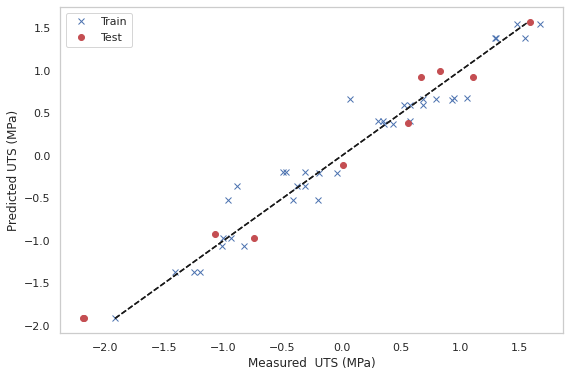

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
#KERNEL
#GBR=GradientBoostingRegressor(n_estimators=100, random_state=0)
GBR=GradientBoostingRegressor(n_estimators=2000, random_state=32, learning_rate=0.1 )

#START TRAINING
GBR.fit(X_train,y_train)
#PREDICTION
y_pred=GBR.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

 
print("-Gradient boosting regressor-")
print("-----------------------------")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

#Plots
sns.set_theme(style="whitegrid")
plt.rcParams["axes.grid"] = False
fig = plt.figure()
fig.set_size_inches((9,6))


plt.plot(y_train, y_star_train, 'bx', label = 'Train')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.plot(y_test, y_pred, 'ro', label = 'Test')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.legend()
plt.ylabel('Predicted UTS (MPa)')
plt.xlabel('Measured  UTS (MPa)') 